#  BM20A6100 Advanced Data Analysis and Machine Learning
## Erik Kuitunen, 0537275

### Kernel Principal Component Analysis


Read data, scale and visualize


In [582]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Flowmeters/Meter A", delimiter="	", header=None)
col_names = df.columns.tolist() 

df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.841499,1.009367,0.993816,8.469805,10.278727,10.037759,8.501365,8.581726,10.247763,10.058822,...,32.451173,34.568685,33.082683,36.722005,36.969403,36.075847,36.051432,35.174155,32.729490,1
1,0.842250,1.006584,0.996605,7.531891,9.139924,8.951618,7.612213,7.623325,9.106345,8.945142,...,32.428385,34.441732,33.081055,36.687825,36.933595,36.054688,35.979818,34.847005,32.731122,1
2,0.840723,1.011647,0.998152,6.641699,7.975464,7.857692,6.593117,6.681572,7.964596,7.814698,...,32.428385,34.275715,33.113605,36.661785,36.873370,36.002605,35.963542,34.689128,32.771810,1
3,0.841119,1.017807,0.996812,5.687524,6.824334,6.689885,5.615428,5.763315,6.801051,6.686639,...,32.485350,34.080403,33.170573,36.673177,36.811525,35.974935,35.955403,34.500328,32.849935,1
4,0.840358,1.016534,0.996221,5.660385,6.829560,6.675628,5.623977,5.736818,6.813453,6.672377,...,32.503255,34.122720,33.164062,36.673177,36.826173,35.996095,35.968425,34.474283,32.853190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.792929,1.006295,0.999666,2.696691,3.414048,3.389731,2.699618,2.715628,3.414042,3.393569,...,32.555338,33.767905,33.300782,36.640627,36.691080,35.849610,35.834960,33.823245,33.012697,2
83,0.792309,1.004472,0.999873,2.679006,3.433638,3.386612,2.714345,2.699840,3.429142,3.380373,...,32.545573,33.769532,33.294272,36.634115,36.692707,35.859377,35.844727,33.819987,33.022460,2
84,0.793471,1.009560,1.001110,2.691553,3.431745,3.364790,2.717383,2.700560,3.432876,3.374046,...,32.561848,33.780925,33.287762,36.635745,36.694335,35.854492,35.831705,33.824870,33.020832,2
85,0.796730,1.010570,0.999029,2.714849,3.412818,3.388927,2.692776,2.738119,3.413739,3.381779,...,32.555338,33.774415,33.302410,36.640627,36.699218,35.859377,35.849610,33.816732,33.011067,2


<Axes: >

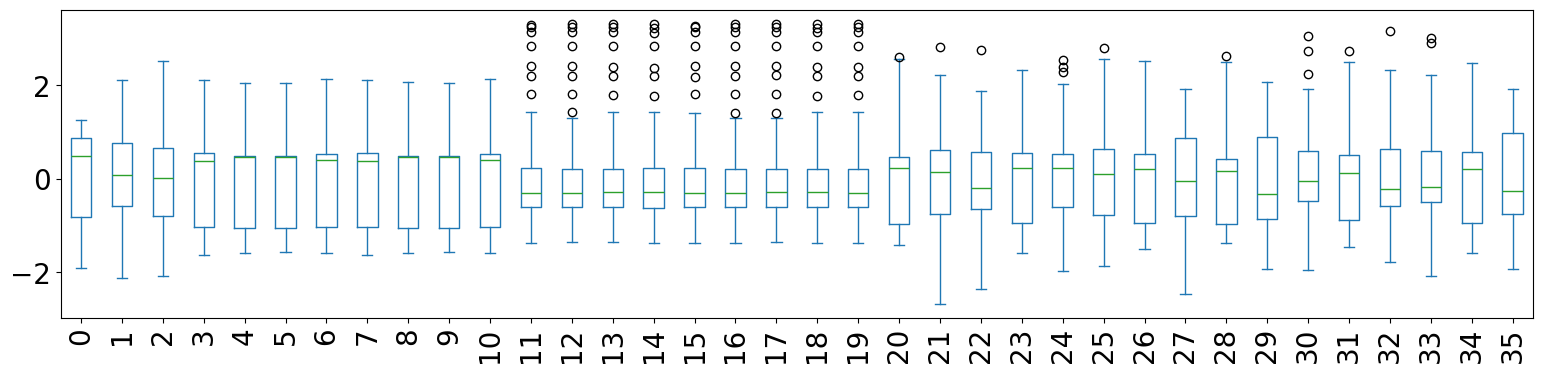

In [583]:
from sklearn.preprocessing import StandardScaler    

XData = df.iloc[ :, :-1 ].values
YData = df.iloc[ :, -1 ].values

scaler = StandardScaler()
scaler.fit( XData )
XData_scaled = scaler.transform( XData )
# YData_scaled = scaler.transform( YData.reshape(-1,1) )

pd.DataFrame( XData_scaled ).plot( kind = 'box', 
                                   figsize = (19,4), 
                                   rot = 90, 
                                   fontsize = 20, 
                                   sharey = False )


Defining kernels

In [584]:
def linear_kernel(X1, X2, sigma = None, degree = None):
    k_xixj = np.dot( X1, X2 )
    return k_xixj

def polynomial_kernel(X1, X2, sigma = None, degree = 2):
    k_xixj = ( np.dot( X1, X2 ) + 1 ) ** degree
    return k_xixj

def gaussian_kernel(X1, X2, sigma = 1, degree = None ):
    k_xixj = np.exp( -np.linalg.norm( X1 - X2 ) ** 2 / ( 2 * sigma ** 2 ) )
    return k_xixj
    

Calculating the Gram matrix using a kernel; centering 

In [585]:
# First using the linear kernel
def gram_centered(  kernel, X, Xhat = None, sigma = None, degree = None ):
    if kernel == 'linear':
        kernel = linear_kernel
    elif kernel == "polynomial":
        kernel = polynomial_kernel
    elif kernel == "gaussian":
        kernel = gaussian_kernel
        
    if Xhat is None:
        Nsamples_i = X.shape[0]
        Nsamples_j = X.shape[0]
        X = X.T
        # Xtest = X
    else:
        X = X.T
        Xhat = Xhat.T
        Nsamples_i = Xhat.shape[1]
        Nsamples_j = X.shape[1]      
        
    # First calculating K for calibration partition
    Kcal = np.zeros( (Nsamples_j, Nsamples_j) )    
    for ii in range(Nsamples_j):
        for jj in range(ii, Nsamples_j):
            elem = kernel( X[ :, ii ], X[ :, jj ], sigma = sigma, degree = degree )
            Kcal[ii, jj] = elem 
            if ii != jj:
                Kcal[jj, ii] = Kcal[ii, jj]
       
    # If fitting the model, return only the centered Gram matrix for calibration set
    if Xhat is None:
        I_n = np.eye( Nsamples_j )
        ones_n = np.ones((Nsamples_j, Nsamples_j))
        multiplier = ( I_n - ones_n / Nsamples_j @ ones_n.T )
        Kcal_hat = multiplier @ Kcal @ multiplier
        return Kcal_hat
    
    
    # If predicting, return the combined centered Gram matrix for calibration and prediction set
    K = np.zeros((Nsamples_i, Nsamples_j))
    for ii in range(Nsamples_i):
        for jj in range(Nsamples_j):
            elem = kernel( Xhat[ :, ii ], X[ :, jj ], sigma = sigma, degree = degree )
            K[ii, jj] = elem 

    ones_n = np.ones( (Nsamples_j, Nsamples_j) ) / Nsamples_j
    ones_ntest = np.ones( (Nsamples_i, Nsamples_j) ) / Nsamples_j
    K = K - ones_ntest @ Kcal - K @ ones_n + ones_ntest @ Kcal @ ones_n
    
    return K

Defining the kPLS algorithm

In [586]:
def kernel_PLS( K, y, n_components):
    n = K.shape[0]
    T = np.zeros( (n, n_components) )
    U = np.zeros( (y.shape[0], n_components) )
    
    # print( "LV's", n_components )
    # print( "TU, 0: ", T.shape, U.shape )
    # print( "y, 0:, ", y.shape )
    # print( "K, 0:, ", K.shape )
    
    for ii in range( n_components ):
        
        # print( "K, ii", K.shape )
        
        t = K @ y
        t = t / np.linalg.norm(t)
        u = y @ ( y.T @ t )
        u = u / np.linalg.norm(u)
        
        # print("t and u:", t.shape, u.shape )
        
        # Store u and t
        T[ :, ii ] = t.reshape(-1)
        U[ :, ii ] = u.reshape(-1)
        
        # Deflate matrices
        K = K - t @ ( t.T @ K )
        y = y - t @ ( t.T @ y )
    
    return T, U

PLS function. No cross-validation, since amont of data is low.

In [587]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler    


def pls_model( X_train, y_train, X_test, y_test, n_comp, kernel = None, sigma = None, degree = None ):
    
    scalerX = StandardScaler().fit( X_train )
    X_train = scalerX.transform( X_train )
    X_test = scalerX.transform( X_test )
    
    scalerY = StandardScaler().fit( y_train.reshape(-1,1) )
    y_train = scalerY.transform( y_train.reshape(-1,1) )
    y_test = scalerY.transform( y_test.reshape(-1,1) )
    
    if kernel is None:
        model = PLSRegression( n_components = n_comp ).fit( X_train, y_train )
        y_pred_train = model.predict( X_train )
        y_pred_test = model.predict( X_test )
        
    else:
        K_train = gram_centered( kernel, X_train, sigma = sigma, degree = degree )
        K_test = gram_centered( kernel, X_train, Xhat = X_test, sigma = sigma, degree = degree )

        # Runnign kernel PLS
        T, U = kernel_PLS( K_train, y_train, n_comp )
        B_train = U @ np.linalg.inv( T.T @ K_train @ U )  @ T.T @ y_train
        y_pred_train = K_train @ B_train
        
        # For test data
        y_pred_test = K_test @ B_train
        

    tss = np.sum( (y_train - np.mean(y_train)) ** 2 )
    press = np.sum( (y_pred_test - y_test) ** 2 )

    q2 = 1 - press / tss
    mse = root_mean_squared_error( y_test, y_pred_test )
    r2 = r2_score( y_train, y_pred_train )

    
    return scalerY.inverse_transform( y_pred_test ), q2, r2, mse



Defining plotting function

In [588]:
def plot_results( q2vec, r2vec, mse_vec, Nvariables, kernel, y_test, y_test_pred ):
    
    TITLEFONT = 24
    AXISFONT = 20
    LEGENDFONT = 18
    
    components = np.arange(1, Nvariables+1)
    
    plt.figure(figsize=(15, 5))
    
    plt.rc('xtick', labelsize=AXISFONT)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=AXISFONT)    # fontsize of the tick labels

    plt.subplot(1, 2, 1)
    plt.plot( components, q2vec, '-', label = r'$Q^2$' )
    plt.plot( components, r2vec, '-', label = r'$R^2$' )
    plt.title( r'$Q^2$ and $R^2$ vs number of LVs', fontsize = TITLEFONT)
    plt.xlabel('No. of LVs', fontsize = AXISFONT )
    plt.ylabel('R2', fontsize = AXISFONT)
    plt.grid()
    plt.legend( fontsize = LEGENDFONT, loc = 'lower center' )
    plt.xticks( [ 0, 10, 20, 30] )

    plt.subplot(1, 2, 2)
    plt.plot( components, mse_vec, marker='o' )
    plt.title( 'MSE vs number of LVs', fontsize = TITLEFONT )
    plt.xlabel( 'No. of LVs', fontsize = AXISFONT )
    plt.ylabel( 'MSE', fontsize = AXISFONT )
    plt.xticks( [ 0, 10, 20, 30] )
    plt.grid()
    
    # plt.subplot(1, 3, 3)
    # plt.plot( y_test, y_test_pred, 'o' )
    # plt.plot( [ min(y_test), max(y_test) ], [ min( y_test_pred ), max( y_test_pred) ] , 'r--' )
    # plt.xlabel( 'y_test', fontsize = 18)
    # plt.ylabel( 'y_predicted', fontsize = 18 )
    # plt.title( 'Predicted vs True values', fontsize = 20 )
    # plt.grid()

    # plt.suptitle(f"PLS metrics, kernel: {kernel}", fontsize = 20 )
    plt.tight_layout()
    
    plt.savefig( f"PLS_metrics_{kernel}.pdf" )
    
    plt.show()
    
   

Test-train split, performing PLS and visualizing metrics

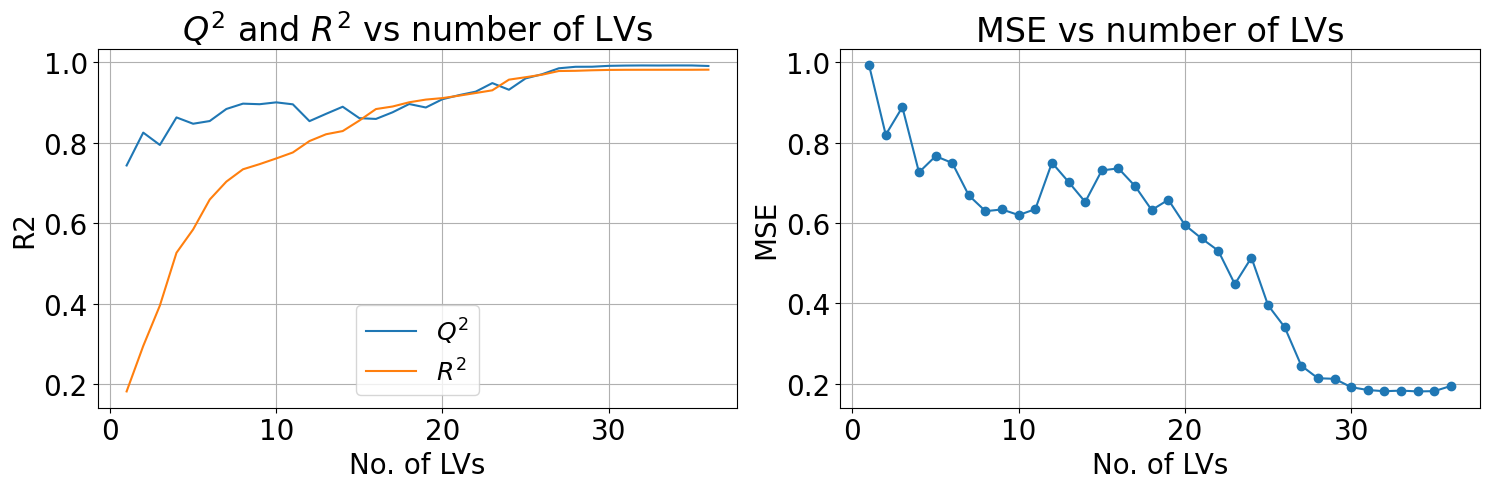

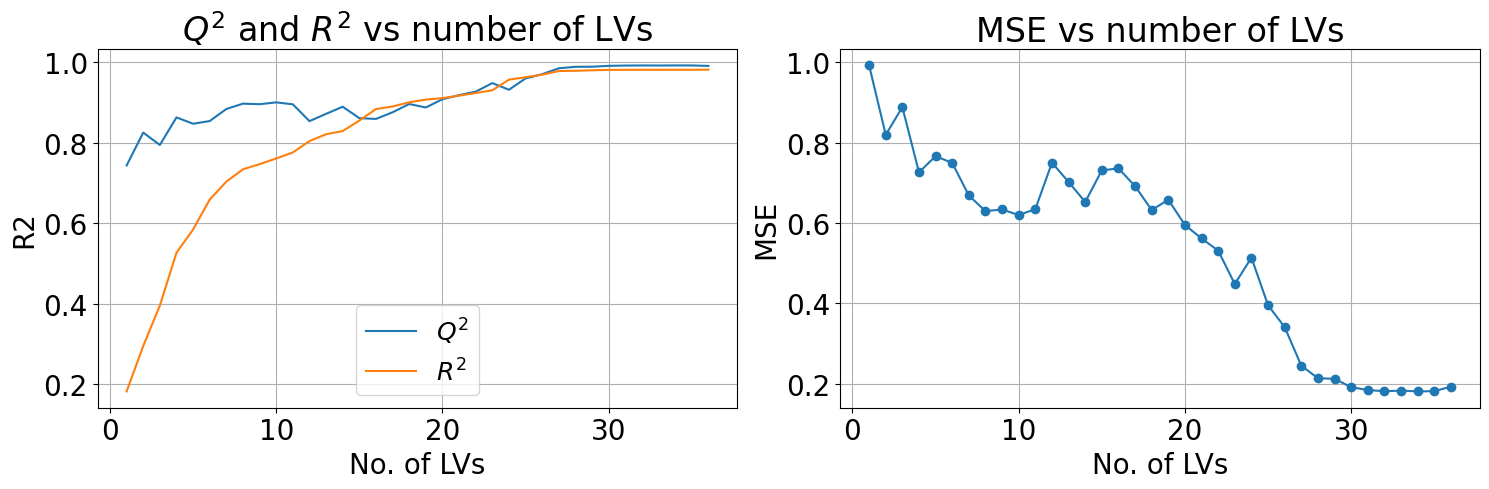

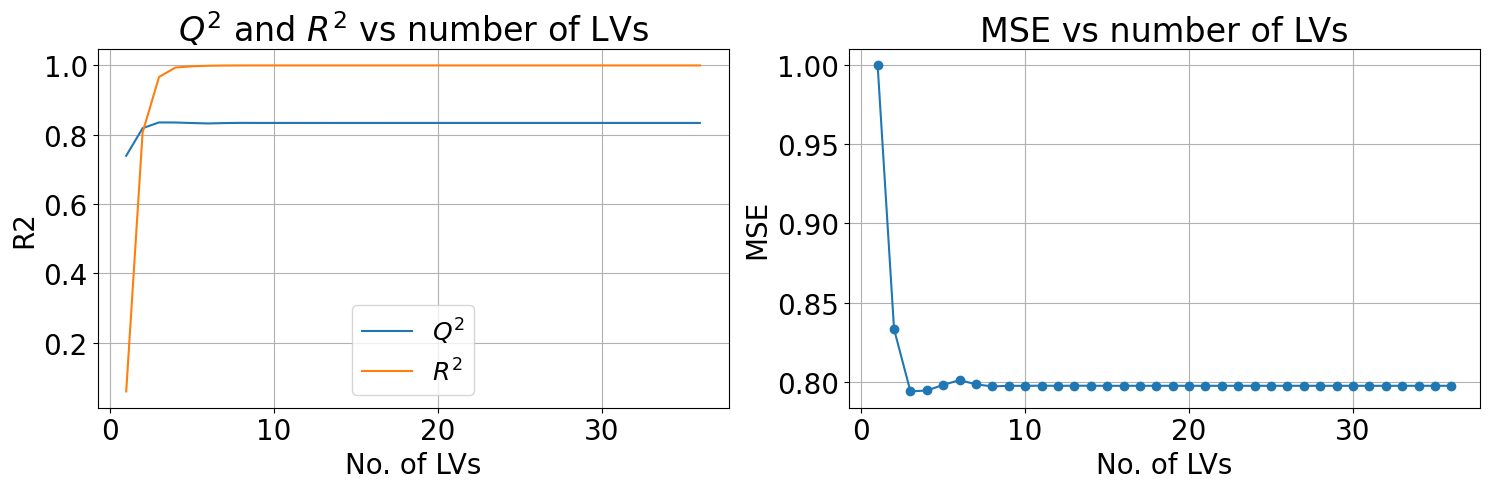

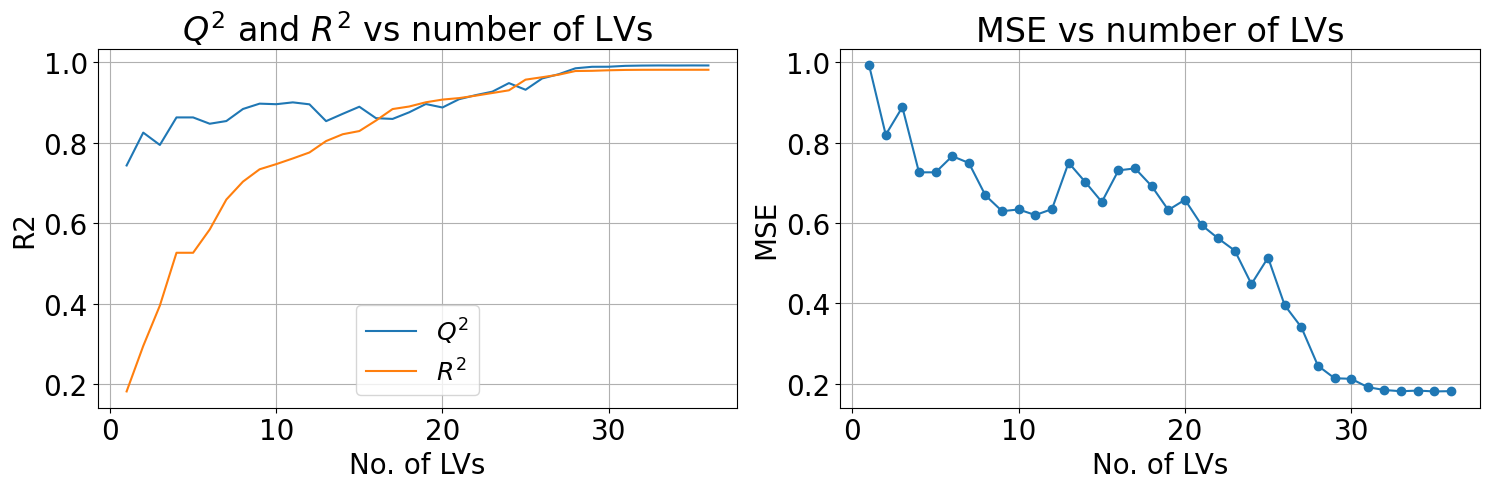

[0.74296871 0.82461262 0.79393675 0.86232732 0.86232868 0.84663403
 0.85333947 0.88328252 0.89654434 0.89515061 0.89972307 0.8948559
 0.85309285 0.87126355 0.88886686 0.86048752 0.85859352 0.8750544
 0.89561423 0.88698797 0.90756509 0.91765799 0.92631143 0.94758653
 0.93105526 0.95920223 0.96969049 0.98435286 0.98808819 0.98824016
 0.99043347 0.99113059 0.99141767 0.99126801 0.99146348 0.99139863]
[0.18173209 0.29461941 0.39496664 0.5261301  0.52614173 0.58402803
 0.65833868 0.70286777 0.7334913  0.74629881 0.76041327 0.77528119
 0.80361885 0.82052592 0.82846422 0.85449789 0.88310816 0.88942973
 0.89993894 0.90661611 0.910321   0.91636874 0.92296322 0.92967823
 0.95613482 0.96217945 0.96851064 0.97758176 0.97809053 0.97943075
 0.98031241 0.9806071  0.98066666 0.98069148 0.98070044 0.98070185]
[0.99261605 0.81995019 0.88876832 0.72646077 0.72645721 0.76674824
 0.74979911 0.66889237 0.62974601 0.63397371 0.61999589 0.63486407
 0.75042927 0.70248824 0.65269471 0.73129874 0.73624599 0.6920

In [589]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( XData, YData, test_size = 0.2, random_state = 42 )

def results( X_train, X_test, y_train, y_test ):
    
    Nvariables = XData.shape[1]

    q2vec = np.zeros( Nvariables )
    r2vec = np.zeros( Nvariables )
    mse_vec = np.zeros( Nvariables )

    for ii in range( Nvariables):
        y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = None )
        q2vec[ ii ] = q2
        r2vec[ ii ] = r2
        mse_vec[ ii ] = mse
        
    plot_results( q2vec, r2vec, mse_vec, Nvariables, "No kernel", y_test, y_pred )

    for ii in range( Nvariables):
        y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = "linear" )
        q2vec[ ii ] = q2
        r2vec[ ii ] = r2
        mse_vec[ ii ] = mse
        
    plot_results( q2vec, r2vec, mse_vec, Nvariables, "Linear", y_test, y_pred )

    for ii in range( Nvariables):
        y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = "gaussian", sigma = 1 )
        q2vec[ ii ] = q2
        r2vec[ ii ] = r2
        mse_vec[ ii ] = mse
        
    plot_results( q2vec, r2vec, mse_vec, Nvariables, "Gaussian", y_test, y_pred )

    for ii in range( Nvariables):
        y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = "polynomial", degree = 1 )
        q2vec[ ii ] = q2
        r2vec[ ii ] = r2
        mse_vec[ ii ] = mse
        
    plot_results( q2vec, r2vec, mse_vec, Nvariables, "Polynomial", y_test, y_pred )
    
    print( q2vec )
    print( r2vec )
    print( mse_vec)

results( X_train, X_test, y_train, y_test )



Using "best" amount of LVs

In [644]:
y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, 23, kernel = None )

accuracy = sum( y_test.reshape(-1) == np.round(y_pred.reshape(-1)) ) / len( y_test )
print( accuracy ) 

y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, 10, kernel="linear" )
accuracy = sum( y_test.reshape(-1) == np.round(y_pred.reshape(-1)) ) / len( y_test )
print(accuracy)


y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, 3, kernel="gaussian", sigma = 1 )
accuracy = sum( y_test.reshape(-1) == np.round(y_pred.reshape(-1)) ) / len( y_test )
print(accuracy)

y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, 5, kernel="polynomial", degree = 2 )
accuracy = sum( y_test.reshape(-1) == np.round(y_pred.reshape(-1)) ) / len( y_test )
print(accuracy)


0.9444444444444444
0.9444444444444444
0.6666666666666666
0.6111111111111112
